## This notebook shows how to use Grizli to

Model and fit G102 + G141 observations for a single object in the CLEAR GS1 and create 1D and 2D spectra and line maps.

** more comments inbound

These series of notebooks draw heavily from Gabe Brammer's existing grizli notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with specific focus for the CLEAR survey.

In [10]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import drizzlepac
import grizli
import glob
from grizli import utils
import importlib
from grizli.prep import process_direct_grism_visit
from hsaquery import query, overlaps
from grizli.pipeline import auto_script
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import os
from grizli.pipeline import photoz
from astropy.table import Table
import eazy
from IPython.display import Image


## The paths defined below need to be changed to your own directories.
### PATH_TO_CATS should include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
### these are all available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/
### HOME_PATH is where the raw data, reduced data, and grizli outputs will be stored


In [3]:
field           = 'GS1'
ref_filter      = 'F105W'
HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_SCRIPTS = '/Users/rsimons/Desktop/git/clear_local/example_notebooks'
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'
PATH_TO_RAW     = glob.glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob.glob(HOME_PATH + '/*/PREP')[0]


class Pointing():
    """ Generalization of GN1, GS1, ERSPRIME, etc

    To change field-dependent catalog, seg map, ref image, and padding
    only need to change them here.

    """
    def __init__(self, field, ref_filter):
        if 'N' in field.upper():
            self.pad = 500 # really only necessary for GDN
            self.radec_catalog = PATH_TO_CATS + '/old_radeccats/goodsN_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_N_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
            
            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodsn_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodsn', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodsn']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodsn', 'v4.1')

        elif 'S' in field.upper():
            self.pad = 200 # grizli default
            self.radec_catalog =  PATH_TO_CATS + '/old_radeccats/goodsS_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_S_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sci.fits'


            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodss_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodss']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodss', 'v4.1')




def readEazyBinary(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY='./OUTPUT', CACHE_FILE='Same'):

    """
    Author: Gabe Brammer
    This function has been clipped from eazyPy.py in thethreedhst git respository
    https://github.com/gbrammer/threedhst/tree/master/threedhst

    tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='photz', \
                                                OUTPUT_DIRECTORY='./OUTPUT', \
                                                CACHE_FILE = 'Same')

    Read Eazy BINARY_OUTPUTS files into structure data.
    
    If the BINARY_OUTPUTS files are not in './OUTPUT', provide either a relative or absolute path
    in the OUTPUT_DIRECTORY keyword.
    
    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+'.tempfilt'.
    Specify the full filename if otherwise. 
    """
    
    #root='COSMOS/OUTPUT/cat3.4_default_lines_zp33sspNoU'
    
    root = OUTPUT_DIRECTORY+'/'+MAIN_OUTPUT_FILE
    
    ###### .tempfilt
    if CACHE_FILE == 'Same':
        CACHE_FILE = root+'.tempfilt'
    
    if os.path.exists(CACHE_FILE) is False:
        print(('File, %s, not found.' %(CACHE_FILE)))
        return -1,-1,-1,-1
    
    f = open(CACHE_FILE,'rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    tempfilt = np.fromfile(file=f,dtype=np.double,count=NFILT*NTEMP*NZ).reshape((NZ,NTEMP,NFILT)).transpose()
    lc = np.fromfile(file=f,dtype=np.double,count=NFILT)
    zgrid = np.fromfile(file=f,dtype=np.double,count=NZ)
    fnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    efnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    
    f.close()
    
    tempfilt  = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
                 'tempfilt':tempfilt,'lc':lc,'zgrid':zgrid,'fnu':fnu,'efnu':efnu}
    
    ###### .coeff
    f = open(root+'.coeff','rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    coeffs = np.fromfile(file=f,dtype=np.double,count=NTEMP*NOBJ).reshape((NOBJ,NTEMP)).transpose()
    izbest = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
    tnorm = np.fromfile(file=f,dtype=np.double,count=NTEMP)
    
    f.close()
    
    coeffs = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
              'coeffs':coeffs,'izbest':izbest,'tnorm':tnorm}
              
    ###### .temp_sed
    f = open(root+'.temp_sed','rb')
    s = np.fromfile(file=f,dtype=np.int32, count=3)
    NTEMP=s[0]
    NTEMPL=s[1]
    NZ=s[2]
    templam = np.fromfile(file=f,dtype=np.double,count=NTEMPL)
    temp_seds = np.fromfile(file=f,dtype=np.double,count=NTEMPL*NTEMP).reshape((NTEMP,NTEMPL)).transpose()
    da = np.fromfile(file=f,dtype=np.double,count=NZ)
    db = np.fromfile(file=f,dtype=np.double,count=NZ)
    
    f.close()
    
    temp_sed = {'NTEMP':NTEMP,'NTEMPL':NTEMPL,'NZ':NZ,\
              'templam':templam,'temp_seds':temp_seds,'da':da,'db':db}
              
    ###### .pz
    if os.path.exists(root+'.pz'):
        f = open(root+'.pz','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=2)
        NZ=s[0]
        NOBJ=s[1]
        chi2fit = np.fromfile(file=f,dtype=np.double,count=NZ*NOBJ).reshape((NOBJ,NZ)).transpose()

        ### This will break if APPLY_PRIOR No
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        
        if len(s) > 0:
            NK = s[0]
            kbins = np.fromfile(file=f,dtype=np.double,count=NK)
            priorzk = np.fromfile(file=f, dtype=np.double, count=NZ*NK).reshape((NK,NZ)).transpose()
            kidx = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
            pz = {'NZ':NZ,'NOBJ':NOBJ,'NK':NK, 'chi2fit':chi2fit, 'kbins':kbins, 'priorzk':priorzk,'kidx':kidx}
        else:
            pz = None
        
        f.close()
        
    else:
        pz = None
    
    if False:
        f = open(root+'.zbin','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        NOBJ=s[0]
        z_a = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_p = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m1 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m2 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_peak = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        f.close()
        
    ###### Done.    
    return tempfilt, coeffs, temp_sed, pz



In [4]:
os.chdir(PATH_TO_PREP)
files = glob.glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


In [5]:
def grizli_model(visits, field = 'GN2', ref_filter_1 = 'F105W', ref_grism_1 = 'G102', ref_filter_2 = 'F140W', ref_grism_2 = 'G141', load_only = True, mag_lim = 25, include_G141 = True):

    all_grism_files = []
    all_direct_files = []
    product_names = np.array([visit['product'] for visit in visits])
    filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
    basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])

    for v, visit in enumerate(visits):
        product = product_names[v]
        basename = basenames[v]
        filt1 = filter_names[v]        
        #filter_name = visit['product'].split('-')[-1]
        field_in_contest = visit['product'].split('-')[0].upper()
        #if field_in_contest.upper() != 'GOODSS':
        #    print (field_in_contest.upper())
            #if field_in_contest == field or field_in_contest in overlapping_fields[field]:
        if (ref_filter_1.lower() in filt1) or (ref_filter_2.lower() in filt1):
            #Find grism files with a direct image
            all_direct_files.extend(visit['files'])
            grism_index_1 = np.where((basenames == basename) & (filter_names == ref_grism_1.lower()))[0]

            if len(grism_index_1) > 0:
                all_grism_files.extend(visits[grism_index_1[0]]['files'])
                print(filter_names[grism_index_1[0]], visits[grism_index_1[0]]['product'])
            if include_G141:
                #Include G141 observatinos
                grism_index_2= np.where((basenames == basename) & (filter_names == ref_grism_2.lower()))[0]

                if len(grism_index_2) > 0:
                    all_grism_files.extend(visits[grism_index_2[0]]['files'])
                    print(filter_names[grism_index_2[0]], visits[grism_index_2[0]]['product'])

    print (all_direct_files, all_grism_files)

    p = Pointing(field=field, ref_filter=ref_filter_1)
    if load_only:
        print('Loading contamination models...')

    grp = GroupFLT(
        grism_files=all_grism_files, 
        direct_files=[], 
        ref_file = p.ref_image,
        seg_file = p.seg_map,
        catalog  = p.catalog,
        pad=p.pad,
        cpu_count=8)

    if not load_only:
        print('Computing contamination models...')
        grp.compute_full_model(mag_limit=mag_lim)
        print('Refining List..')
        grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)
        print('Saving contamination models')
        grp.save_full_data()
    return grp


mag_lim = 21

grp = grizli_model(visits, field = field, ref_filter_1 = 'F105W', ref_grism_1 = 'G102', ref_filter_2 = 'F140W', ref_grism_2 = 'G141',
                   load_only = True, mag_lim = mag_lim)


g141 goodss-01-bhj-01-177.0-g141
g102 gs1-cxt-09-227.0-g102
g102 gs1-cxt-10-227.0-g102
g102 gs1-cxt-07-249.0-g102
g102 gs1-cxt-08-249.0-g102
g102 gs1-cxt-11-269.0-g102
g102 gs1-cxt-12-269.0-g102
['ibhj01ioq_flt.fits', 'ibhj01ivq_flt.fits', 'ibhj01j2q_flt.fits', 'ibhj01j9q_flt.fits', 'icxt09ezq_flt.fits', 'icxt09f4q_flt.fits', 'icxt10daq_flt.fits', 'icxt10dhq_flt.fits', 'icxt07dwq_flt.fits', 'icxt07e1q_flt.fits', 'icxt08e6q_flt.fits', 'icxt08ebq_flt.fits', 'icxt11qhq_flt.fits', 'icxt11qmq_flt.fits', 'icxt12quq_flt.fits', 'icxt12qzq_flt.fits'] ['ibhj01iqq_flt.fits', 'ibhj01ixq_flt.fits', 'ibhj01j4q_flt.fits', 'ibhj01jbq_flt.fits', 'icxt09f0q_flt.fits', 'icxt09f2q_flt.fits', 'icxt09f5q_flt.fits', 'icxt09f7q_flt.fits', 'icxt10dbq_flt.fits', 'icxt10deq_flt.fits', 'icxt10diq_flt.fits', 'icxt10dkq_flt.fits', 'icxt07dxq_flt.fits', 'icxt07dzq_flt.fits', 'icxt07e2q_flt.fits', 'icxt07e4q_flt.fits', 'icxt08e7q_flt.fits', 'icxt08e9q_flt.fits', 'icxt08ecq_flt.fits', 'icxt08eeq_flt.fits', 'icxt11qiq_

In [6]:
p = Pointing(field = field, ref_filter = ref_filter)
eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', 
                         path_is_env=False)
templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Load individual line templates for fitting the line fluxes
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=p.translate_file, 
                        zeropoint_file=None, params=p.params, 
                        load_prior=True, load_products=False)

ep = photoz.EazyPhot(ez, grizli_templates=templ0, zgrid=ez.zgrid)







File, /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.tempfilt, not found.
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_upd

## Let's fit a single object, ID = 43404

In [7]:
id_fit = 43403
beams = grp.get_beams(id_fit, size=80)
print("beams: ", beams)
mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
mb.write_master_fits()

# Fit polynomial model for initial continuum subtraction
wave = np.linspace(2000,2.5e4,100)
poly_templates = grizli.utils.polynomial_templates(
    wave=wave, 
    order=7,
    line=False)

pfit = mb.template_at_z(
    z=0, 
    templates=poly_templates, 
    fit_background=True, 
    fitter='lstsq', 
    fwhm=1400, 
    get_uncertainties=2)


beams:  [<grizli.model.BeamCutout object at 0x1c29fa58d0>, <grizli.model.BeamCutout object at 0x1cad5abb38>, <grizli.model.BeamCutout object at 0x1c224024e0>, <grizli.model.BeamCutout object at 0x1cc8db3f60>, <grizli.model.BeamCutout object at 0x1cbe212ef0>, <grizli.model.BeamCutout object at 0x1cbe23dd30>, <grizli.model.BeamCutout object at 0x1ccbc9ec18>, <grizli.model.BeamCutout object at 0x1ccd172fd0>, <grizli.model.BeamCutout object at 0x1ccd194f98>, <grizli.model.BeamCutout object at 0x1ccd891e48>, <grizli.model.BeamCutout object at 0x1ccd8bcc88>, <grizli.model.BeamCutout object at 0x1ccdc49f98>, <grizli.model.BeamCutout object at 0x1ccf3e2f98>, <grizli.model.BeamCutout object at 0x1ccf407d30>, <grizli.model.BeamCutout object at 0x1ccfac9c18>, <grizli.model.BeamCutout object at 0x1ccfe5efd0>, <grizli.model.BeamCutout object at 0x1ccfe81f98>, <grizli.model.BeamCutout object at 0x1cd0580e48>, <grizli.model.BeamCutout object at 0x1cd05a8c88>, <grizli.model.BeamCutout object at 0x1cd0

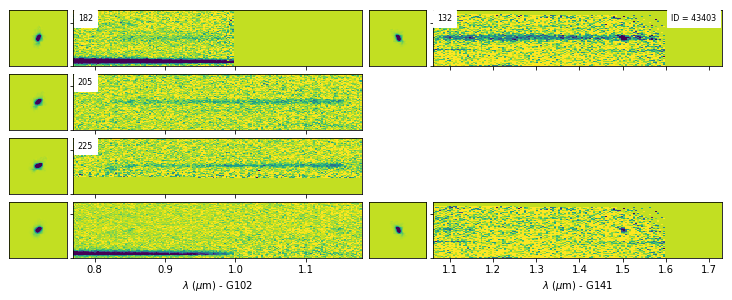

In [8]:
hdu, fig = mb.drizzle_grisms_and_PAs(
    size=32, 
    fcontam=0.2, 
    flambda=False, 
    scale=1, 
    pixfrac=0.5, 
    kernel='point', 
    make_figure=True, 
    usewcs=False, 
    zfit=pfit,
    diff=True)
# Save drizzled ("stacked") 2D trace as PNG and FITS
fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)



1 ibhj01iqq_flt.fits G141
2 ibhj01ixq_flt.fits G141
3 ibhj01j4q_flt.fits G141
4 ibhj01jbq_flt.fits G141
5 icxt09f0q_flt.fits G102
6 icxt09f2q_flt.fits G102
7 icxt09f5q_flt.fits G102
8 icxt09f7q_flt.fits G102
9 icxt10dbq_flt.fits G102
10 icxt10deq_flt.fits G102
11 icxt10diq_flt.fits G102
12 icxt10dkq_flt.fits G102
13 icxt07dxq_flt.fits G102
14 icxt07dzq_flt.fits G102
15 icxt07e2q_flt.fits G102
16 icxt07e4q_flt.fits G102
17 icxt08e7q_flt.fits G102
18 icxt08e9q_flt.fits G102
19 icxt08ecq_flt.fits G102
20 icxt08eeq_flt.fits G102
21 icxt11qiq_flt.fits G102
22 icxt11qkq_flt.fits G102
23 icxt11qnq_flt.fits G102
24 icxt11qpq_flt.fits G102
25 icxt12qvq_flt.fits G102
26 icxt12qxq_flt.fits G102
27 icxt12r0q_flt.fits G102
28 icxt12r2q_flt.fits G102
Load file GS1_43403.stack.fits
  G102 G141
User templates! N=16 

  0.0000    7747.6 (0.0000) 1/377
  0.0040    7747.2 (0.0040) 2/377
  0.0080    7747.7 (0.0040) 3/377
  0.0121    3368.2 (0.0121) 4/377
  0.0161    3368.5 (0.0121) 5/377
  0.0202    3368.

  1.0057    3315.6 (0.1008) 175/377
  1.0138    3311.7 (1.0138) 176/377
  1.0218    3310.6 (1.0218) 177/377
  1.0299    3307.5 (1.0299) 178/377
  1.0381    3299.1 (1.0381) 179/377
  1.0462    3292.6 (1.0462) 180/377
  1.0544    3291.6 (1.0544) 181/377
  1.0627    3290.6 (1.0627) 182/377
  1.0709    3282.8 (1.0709) 183/377
  1.0792    3273.6 (1.0792) 184/377
  1.0876    3261.0 (1.0876) 185/377
  1.0959    3253.5 (1.0959) 186/377
  1.1043    3251.4 (1.1043) 187/377
  1.1128    3246.9 (1.1128) 188/377
  1.1212    3241.4 (1.1212) 189/377
  1.1297    3239.5 (1.1297) 190/377
  1.1383    3242.1 (1.1297) 191/377
  1.1468    3245.2 (1.1297) 192/377
  1.1555    3240.0 (1.1297) 193/377
  1.1641    3236.9 (1.1641) 194/377
  1.1728    3237.0 (1.1641) 195/377
  1.1815    3236.3 (1.1815) 196/377
  1.1902    3233.2 (1.1902) 197/377
  1.1990    3227.8 (1.1990) 198/377
  1.2078    3217.3 (1.2078) 199/377
  1.2167    3202.0 (1.2167) 200/377
  1.2255    3196.4 (1.2255) 201/377
  1.2345    3204.1 (1.2255) 

  3.3060    4166.0 (1.2796) 366/377
  3.3232    4190.0 (1.2796) 367/377
  3.3405    4217.9 (1.2796) 368/377
  3.3579    4242.0 (1.2796) 369/377
  3.3754    4261.2 (1.2796) 370/377
  3.3929    4277.4 (1.2796) 371/377
  3.4106    4291.6 (1.2796) 372/377
  3.4282    4384.3 (1.2796) 373/377
  3.4460    4400.3 (1.2796) 374/377
  3.4638    4416.9 (1.2796) 375/377
  3.4817    4433.9 (1.2796) 376/377
  3.4997    4453.9 (1.2796) 377/377
First iteration: z_best=1.2796

- 1.2758    2865.4 (1.2758) 1/33
- 1.2763    2850.8 (1.2763) 2/33
- 1.2768    2836.4 (1.2768) 3/33
- 1.2773    2822.3 (1.2773) 4/33
- 1.2778    2808.6 (1.2778) 5/33
- 1.2783    2795.4 (1.2783) 6/33
- 1.2788    2783.0 (1.2788) 7/33
- 1.2793    2771.3 (1.2793) 8/33
- 1.2798    2760.6 (1.2798) 9/33
- 1.2803    2750.8 (1.2803) 10/33
- 1.2808    2742.0 (1.2808) 11/33
- 1.2813    2734.4 (1.2813) 12/33
- 1.2818    2727.8 (1.2818) 13/33
- 1.2823    2722.4 (1.2823) 14/33
- 1.2828    2718.2 (1.2828) 15/33
- 1.2833    2715.3 (1.2833) 16/33
-

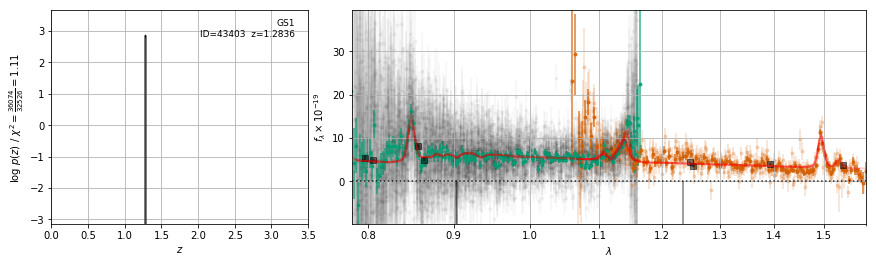

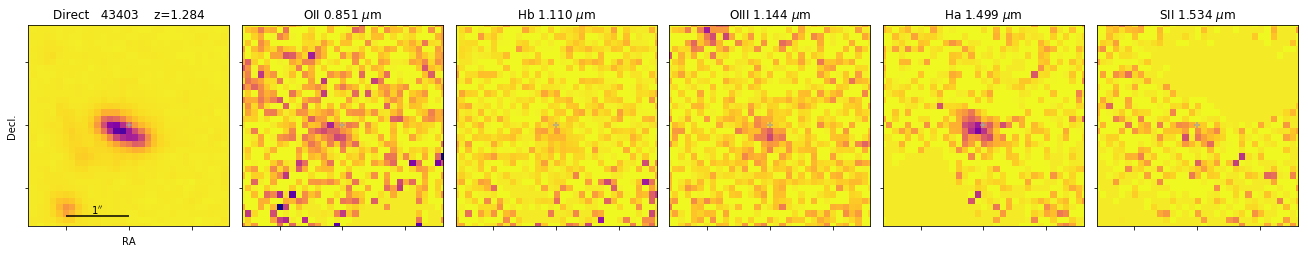

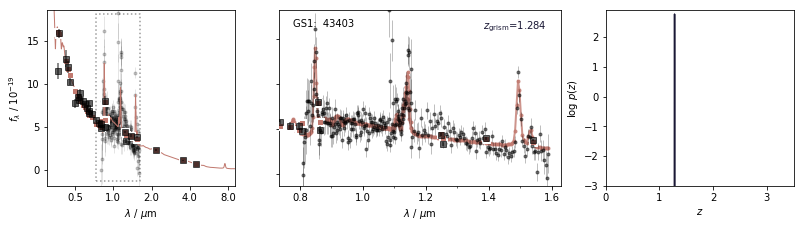

In [8]:
tab = utils.GTable()
tab['ra'] = [mb.ra]
tab['dec'] = [mb.dec]
tab['id'] = id_fit
phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])
out = grizli.fitting.run_all(
    id_fit, 
    t0=templ0, 
    t1=templ1, 
    fwhm=1200, 
    zr=[0.0, 3.5], 
    dz=[0.004, 0.0005], 
    fitter='nnls',
    group_name=field,
    fit_stacks=True, 
    prior=None, 
    fcontam=0.,
    pline=pline, 
    mask_sn_limit=7, 
    fit_only_beams=False,
    fit_beams=True, 
    root=field,
    fit_trace_shift=False, 
    phot=phot, 
    verbose=True, 
    scale_photometry= 0, 
    show_beams=True)

In [9]:
mb, st, fit, tfit, line_hdu = out
fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

fit_hdu.info()
# same as the fit table above, redshift fit to the stacked spectra
fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


# zoom in around the initial best-guess with the individual "beam" spectra
fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

templ = Table(fit_hdu['TEMPL'].data)
print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

# Helper script for plotting them, not generated automatically
fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
plt.close('all')

Filename: GS1_43403.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   ()      
  1  ZFIT_STACK    1 BinTableHDU    238   410R x 6C   [D, D, 18D, 324D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     76   62R x 6C   [D, D, 44D, 1936D, D, D]   
  3  TEMPL         1 BinTableHDU    210   8391R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       153   (64, 64)   float64   
  5  DSCI          1 ImageHDU        20   (80, 80)   float32   
  6  DWHT          1 ImageHDU        20   (80, 80)   float32   
  7  LINE        SII ImageHDU        24   (80, 80)   float32   
  8  CONTINUUM   SII ImageHDU        24   (80, 80)   float32   
  9  CONTAM      SII ImageHDU        24   (80, 80)   float32   
 10  LINEWHT     SII ImageHDU        24   (80, 80)   float32   
 11  LINE        Ha  ImageHDU        24   (80, 80)   float32   
 12  CONTINUUM   Ha  ImageHDU        24   (80, 80)   float32   
 13  CONTAM      Ha  ImageHDU        24   (80, 80) 

# Grizli products

### Stack of Grism orients

left:  G102

right: G141

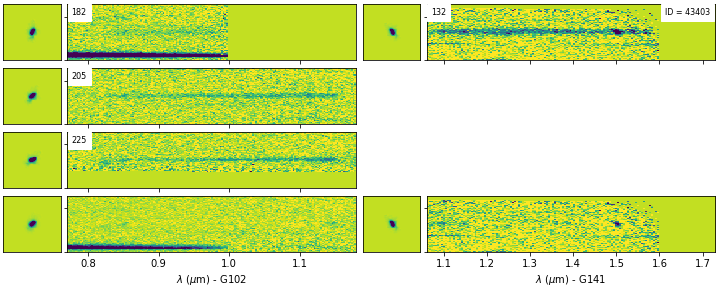

In [12]:
Image(filename = PATH_TO_PREP + '/GS1_43403.stack.png', width = 1000, height = 1000)

### SED fit

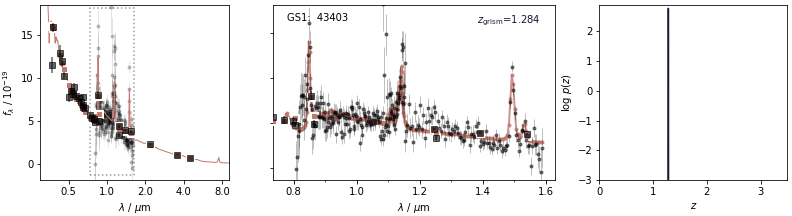

In [20]:
Image(filename = PATH_TO_PREP + '/GS1_43403.sed.png', width = 1000, height = 1000)

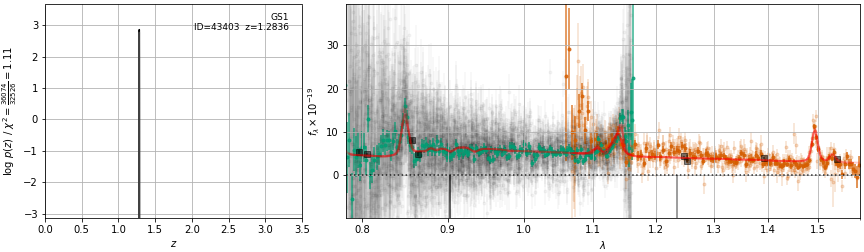

In [21]:
Image(filename = PATH_TO_PREP + '/GS1_43403.full.png', width = 1000, height = 1000)

### Emission Line Map

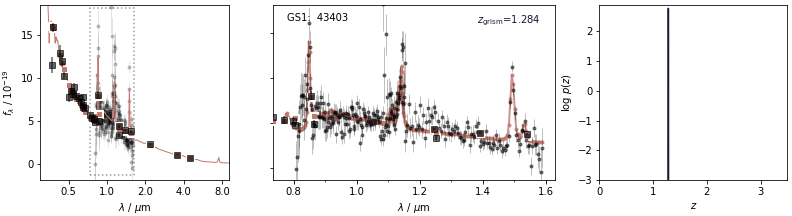

In [15]:
Image(filename = PATH_TO_PREP + '/GS1_43403.line.png', width = 1000, height = 1000)

## Let's fit every object in the field with jh mag < 22

In [10]:
def grizli_fit(grp, id_fit, field = '', ref_filter = 'F105W', use_pz_prior = True, use_phot = True, scale_phot = True, templ0 = None, templ1 = None, ep = None, pline = None):
    beams = grp.get_beams(id_fit, size=80)
    if beams != []:
        print("beams: ", beams)
        mb = grizli.multifit.MultiBeam(beams, fcontam=1.0, group_name=field)
        mb.write_master_fits()

        # Fit polynomial model for initial continuum subtraction
        wave = np.linspace(2000,2.5e4,100)
        poly_templates = grizli.utils.polynomial_templates(
            wave=wave, 
            order=7,
            line=False)

        pfit = mb.template_at_z(
            z=0, 
            templates=poly_templates, 
            fit_background=True, 
            fitter='lstsq', 
            fwhm=1400, 
            get_uncertainties=2)


        if pfit != None:
        # Drizzle grisms / PAs
            hdu, fig = mb.drizzle_grisms_and_PAs(
                size=32, 
                fcontam=0.2, 
                flambda=False, 
                scale=1, 
                pixfrac=0.5, 
                kernel='point', 
                make_figure=True, 
                usewcs=False, 
                zfit=pfit,
                diff=True)
            # Save drizzled ("stacked") 2D trace as PNG and FITS
            fig.savefig('{0}_{1:05d}.stack.png'.format(field, id_fit))
            hdu.writeto('{0}_{1:05d}.stack.fits'.format(field, id_fit), clobber=True)



            if use_pz_prior:
                #use redshift prior from z_phot
                prior = np.zeros((2, len(p.tempfilt['zgrid'])))
                prior[0] = p.tempfilt['zgrid']
                prior[1] = p.pz['chi2fit'][:,id]
            else:
                prior = None 
            order = 0



            tab = utils.GTable()
            tab['ra'] = [mb.ra]
            tab['dec'] = [mb.dec]

            tab['id'] = id_fit
            phot, ii, dd = ep.get_phot_dict(tab['ra'][0], tab['dec'][0])
            out = grizli.fitting.run_all(
                id_fit, 
                t0=templ0, 
                t1=templ1, 
                fwhm=1200, 
                zr=[0.0, 3.5], 
                dz=[0.004, 0.0005], 
                fitter='nnls',
                group_name=field,
                fit_stacks=True, 
                prior=None, 
                fcontam=0.,
                pline=pline, 
                mask_sn_limit=7, 
                fit_only_beams=False,
                fit_beams=True, 
                root=field,
                fit_trace_shift=False, 
                phot=phot, 
                verbose=True, 
                scale_photometry=order, 
                show_beams=True)
            mb, st, fit, tfit, line_hdu = out
            fit_hdu = fits.open('{0}_{1:05d}.full.fits'.format(field, id_fit)) 

            fit_hdu.info()
            # same as the fit table above, redshift fit to the stacked spectra
            fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 


            # zoom in around the initial best-guess with the individual "beam" spectra
            fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   

            templ = Table(fit_hdu['TEMPL'].data)
            print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

            # Helper script for plotting them, not generated automatically
            fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
            fig.savefig('{0}_{1:05d}.line.png'.format(field, id_fit))
            plt.close('all')


In [11]:
if False:
    good = np.where(np.array(grp.catalog['MAG_AUTO']) < 22)[0]
    for g in good:
        id_fit = np.array(grp.catalog['NUMBER'])[g]
        mag_fit = grp.catalog['MAG_AUTO'][g]
        grizli_fit(grp, id_fit = id_fit, field = field,
                   use_pz_prior = False, use_phot = True, scale_phot = True,
                   templ0 = templ0, templ1 = templ1, ep = ep, pline = pline,)
        


        


In [12]:
import prospect